### Visualising Convergence Rate

In [1]:
!pip install matplotlib

In [38]:
import re
import ast
import matplotlib.pyplot as plt

def load_accuracy(path):
    with open(path, 'r') as f:
        log_contents = f.read()

    match = re.search(r"metrics_centralized\s+({.*?})", log_contents)

    if match:
        metrics_dict = ast.literal_eval(match.group(1))
        if 'accuracy' in metrics_dict:
            return metrics_dict['accuracy']
        
def load_loss(path):
    """Extract loss as list of (round, loss) tuples"""
    with open(path, 'r') as f:
        log_contents = f.read()

    match = re.search(r"losses_centralized\s+\[(.*?)\]", log_contents, re.DOTALL)
    if match:
        try:
            loss_list = ast.literal_eval("[" + match.group(1).strip() + "]")
            return loss_list
        except Exception as e:
            print(f"Error parsing loss from {path}: {e}")
    return []

def visualise_data(path):
    with open(path, 'r') as f:
        log_contents = f.read()

    accuracy_match = re.search(r"metrics_centralized\s+({.*?})", log_contents)
    loss_match = re.search(r"losses_centralized\s+\[(.*?)\]", log_contents, re.DOTALL)

    plt.figure(figsize=(12, 5))

    # Plot accuracy if available
    if accuracy_match:
        metrics_dict = ast.literal_eval(accuracy_match.group(1))
        if 'accuracy' in metrics_dict:
            epochs, accuracies = zip(*metrics_dict['accuracy'])
            plt.subplot(1, 2, 1)
            plt.plot(epochs, accuracies, marker='o', color='blue')
            plt.title("Accuracy over Epochs")
            plt.ylim(0, 1)
            plt.xlabel("Round")
            plt.ylabel("Accuracy")
            plt.grid(True)

    if loss_match:
        loss_str = "[" + loss_match.group(1).strip() + "]"
        try:
            loss_list = ast.literal_eval(loss_str)
            loss_epochs, losses = zip(*loss_list)
            plt.subplot(1, 2, 2)
            plt.plot(loss_epochs, losses, marker='x', color='red')
            plt.title("Loss over Epochs")
            plt.xlabel("Round")
            plt.ylabel("Loss")
            plt.grid(True)
        except Exception as e:
            print("Error parsing losses:", e)

def plot_subplots(acc_datasets, loss_datasets):
    plt.rcParams['font.family'] = 'Nimbus Roman'
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

    # Plot accuracies (top row)
    for ax, (title, data) in zip(axes[0], acc_datasets.items()):
        if data:
            epochs, accuracies = zip(*data)
            ax.plot(epochs, accuracies, marker='o', color='blue')
        ax.set_title(f"{title} - GMA", fontsize=16)
        ax.set_xlabel("Round", fontsize=14)
        ax.set_ylabel("Accuracy", fontsize=14)
        ax.set_ylim(0, 1.0)
        ax.grid(True)

    # Plot losses (bottom row)
    for ax, (title, data) in zip(axes[1], loss_datasets.items()):
        if data:
            epochs, losses = zip(*data)
            ax.plot(epochs, losses, marker='x', color='red')
        ax.set_title(f"{title} - Loss", fontsize=16)
        ax.set_xlabel("Round", fontsize=14)
        ax.set_ylabel("Loss", fontsize=14)
        ax.grid(True)

    fig.suptitle("Global Main Task Accuracy and Loss Over Rounds Under Different Poisoning Rates", fontsize=22)
    plt.tight_layout(rect=[0, 0, 1, 1])  # Reserve space for suptitle
    plt.show()

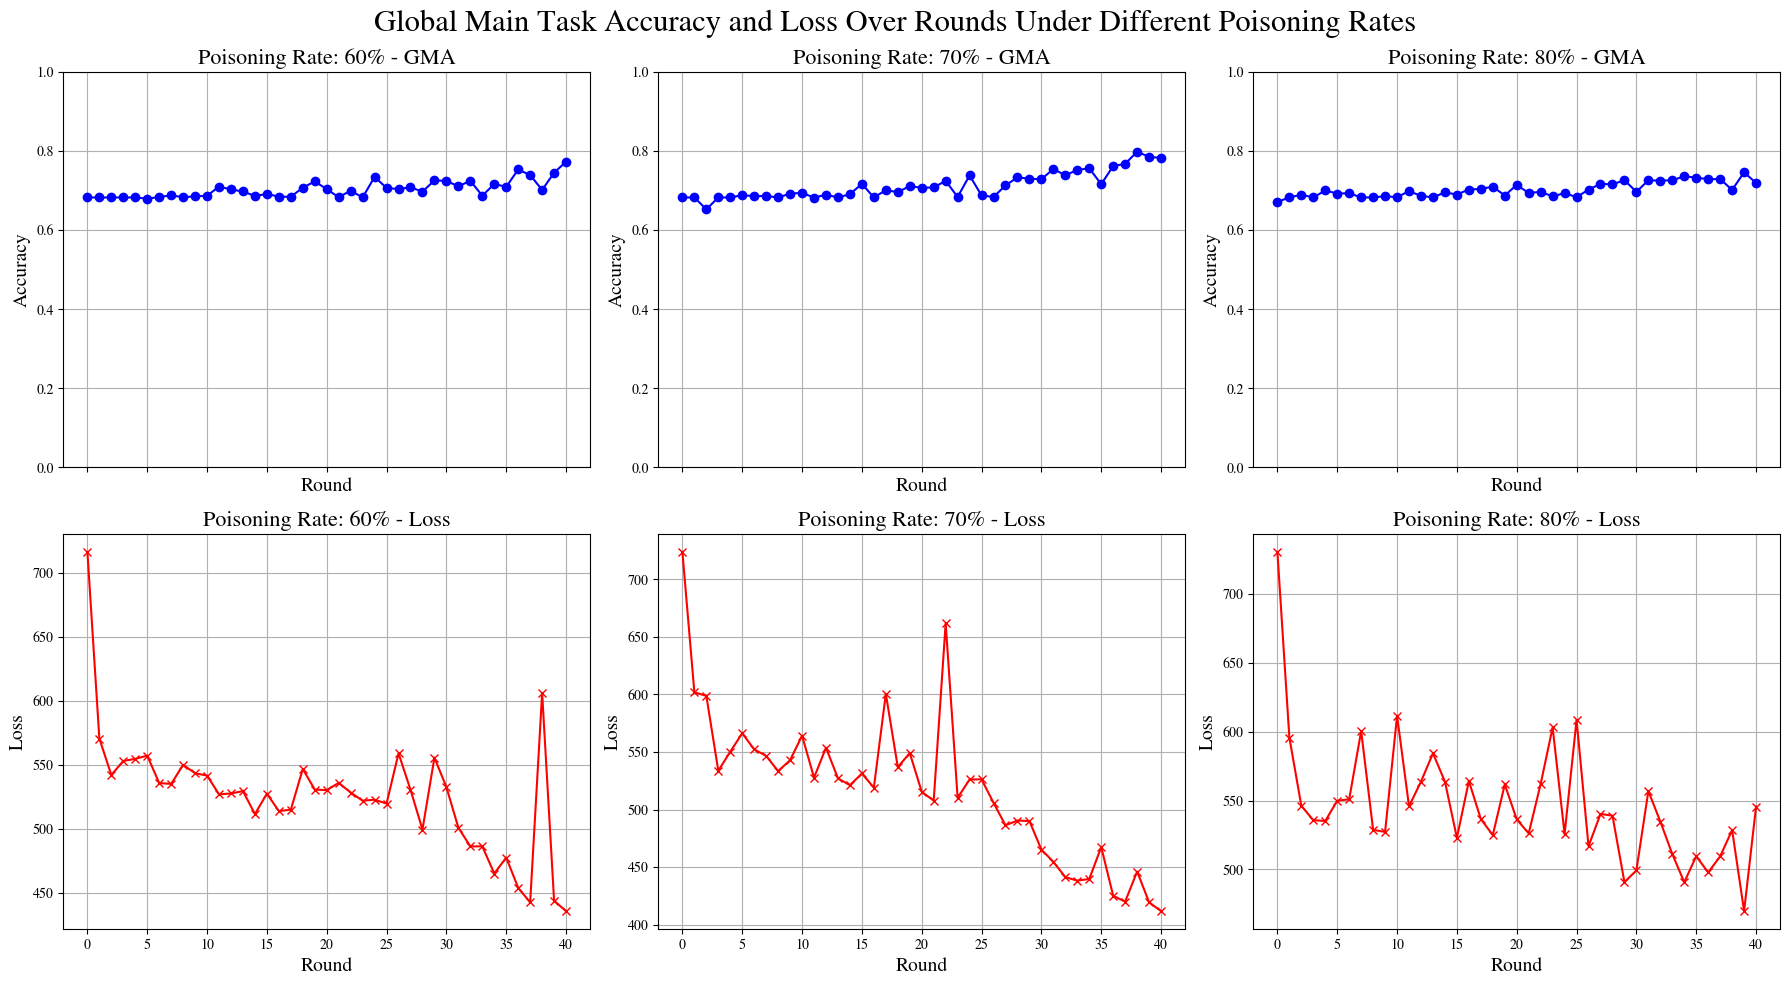

In [39]:
pr80_celeba = 'outputs/2024-12-13/16-17-43/main.log'
pr70_celeba = 'outputs/2024-12-12/23-48-00/main.log'
pr60_celeba = 'outputs/2024-12-13/13-15-11/main.log'

# Load accuracy
acc_dict = {
    "Poisoning Rate: 60%": load_accuracy(pr60_celeba),
    "Poisoning Rate: 70%": load_accuracy(pr70_celeba),
    "Poisoning Rate: 80%": load_accuracy(pr80_celeba),
}

# Load loss
loss_dict = {
    "Poisoning Rate: 60%": load_loss(pr60_celeba),
    "Poisoning Rate: 70%": load_loss(pr70_celeba),
    "Poisoning Rate: 80%": load_loss(pr80_celeba),
}

# Plot
plot_subplots(acc_dict, loss_dict)

# Plot GMA and GBA

In [83]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_log(file_path):
    gma_values = []
    gba_values = []

    with open(file_path, 'r') as f:
        for line in f:
            if "Federated Accuracy on Clean Data (GMA)" in line:
                match = re.search(r'GMA\):\s*([0-9.]+)', line)
                if match:
                    gma_values.append(float(match.group(1)))
            elif "Global Poisoning Accuracy on Dirty Data (GBA)" in line:
                match = re.search(r'GBA\):\s*([0-9.]+)', line)
                if match:
                    gba_values.append(float(match.group(1)))
    
    return gma_values, gba_values

def plot_metrics(log_files, labels=None, pr=0.8):
    plt.figure(figsize=(12, 5), dpi=150)
    plt.rcParams['font.family'] = 'Nimbus Roman'

    # Plot GMA
    plt.subplot(1, 2, 1)
    for idx, file in enumerate(log_files):
        gma, _ = extract_metrics_from_log(file)
        label = labels[idx] if labels else f"Method {idx+1}"
        # plt.plot(gma, label=label) #, marker='o'
        plt.plot(gma, label=label, linewidth=2.5) if label == 'FedAssets' else  plt.plot(gma, label=label, alpha = 0.4)
    plt.title("GMA (Global Main Task Accuracy)", fontsize=16)
    plt.ylim(0,1)
    plt.xlabel("Round", fontsize=15)
    plt.ylabel("Clean Accuracy", fontsize=15)
    plt.legend()
    plt.grid(False)

    # Plot GBA
    plt.subplot(1, 2, 2)
    for idx, file in enumerate(log_files):
        _, gba = extract_metrics_from_log(file)
        label = labels[idx] if labels else f"Method {idx+1}"
        plt.plot(gba, label=label, linewidth=2.5) if label == 'FedAssets' else  plt.plot(gba, label=label, alpha = 0.4)
    plt.title("GBA (Global Backdoor Accuracy)", fontsize=16)
    plt.xlabel("Round", fontsize=15)
    plt.ylabel("Backdoor Accuracy", fontsize=15)
    plt.legend()
    plt.grid(False)

    plt.suptitle(f"Global Model Performance of varying methods in PR = {pr}", fontsize=18)
    plt.tight_layout()
    plt.show()


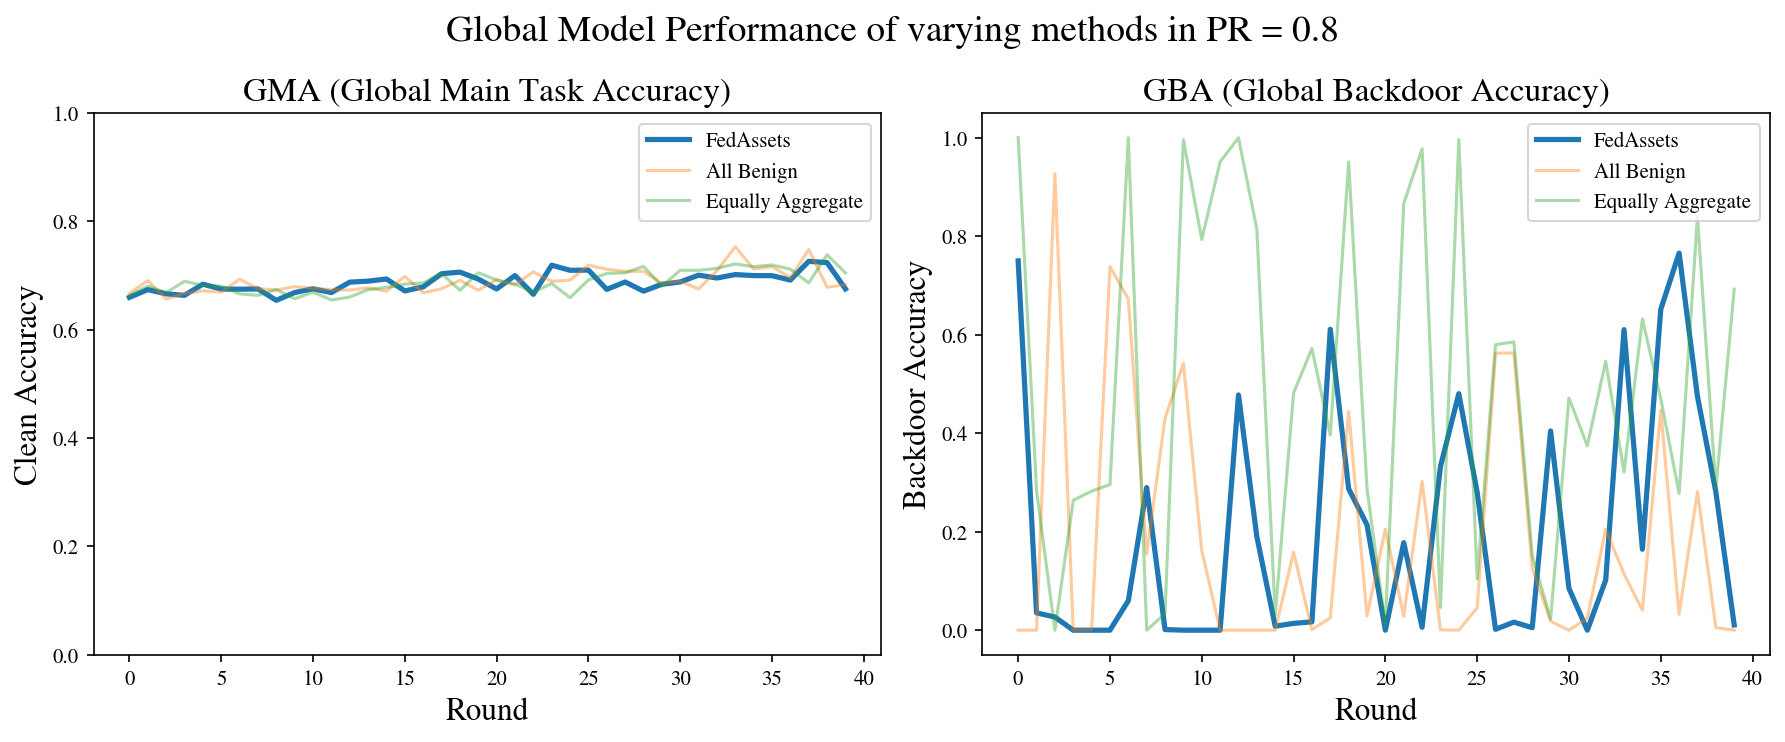

In [84]:
log_paths = [
    'outputs/2024-12-13/21-24-56/main.log',
    'outputs/2024-12-13/17-56-42/main.log',
    'outputs/2024-12-13/16-17-43/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.8)

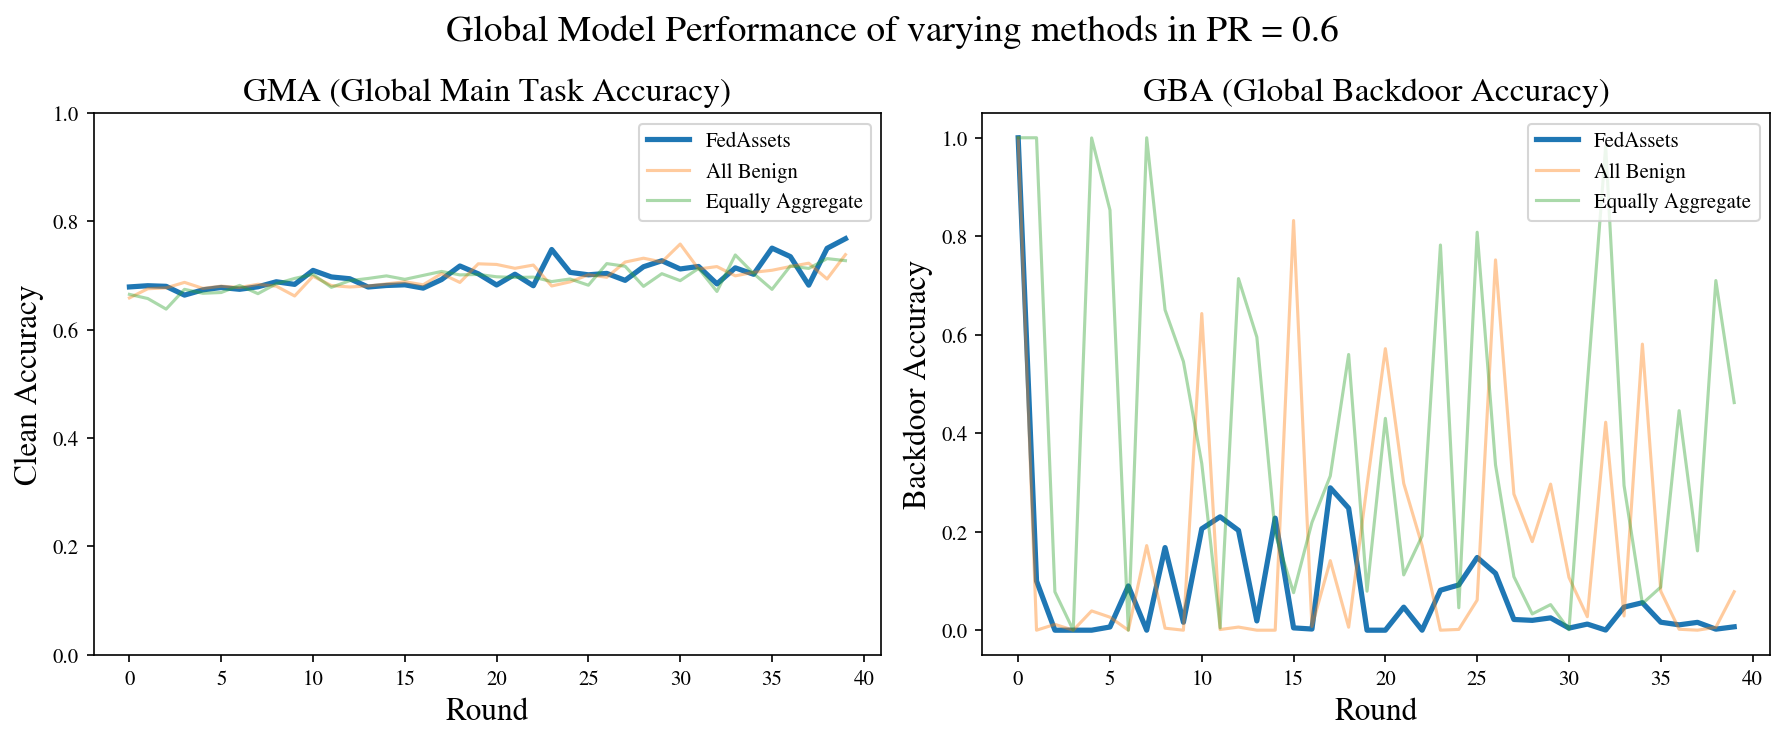

In [85]:
log_paths = [
    'outputs/2024-12-13/13-15-12/main.log',
    'outputs/2024-12-13/09-21-31/main.log',
    'outputs/2024-12-13/07-35-46/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.6)

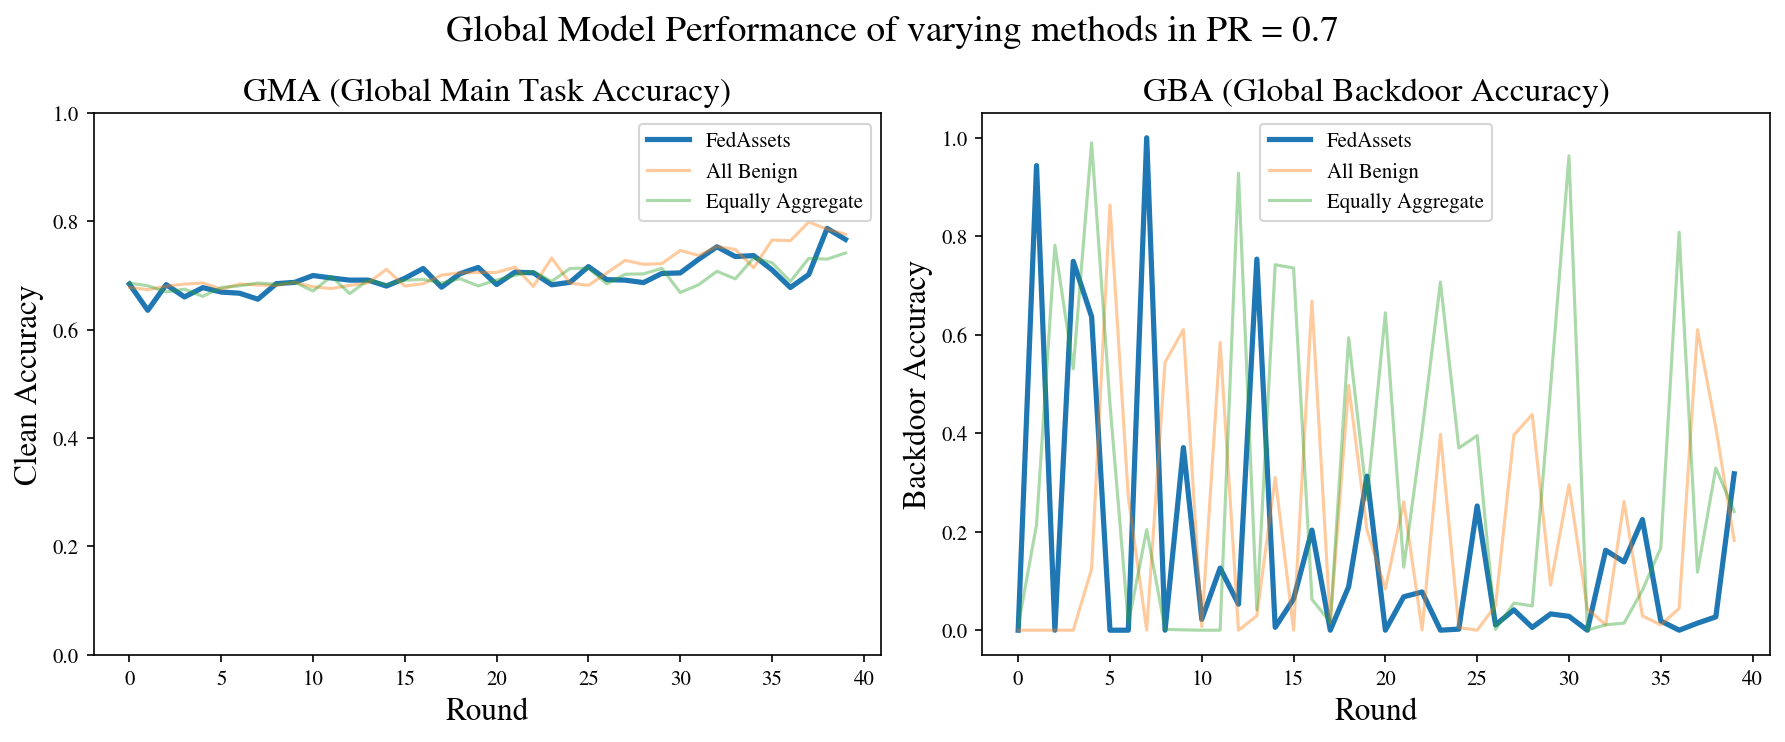

In [86]:
log_paths = [
    'outputs/2024-12-12/19-55-50/main.log',
    'outputs/2024-12-12/23-48-00/main.log',
    'outputs/2024-12-12/22-18-16/main.log'
]

labels = ['FedAssets', 'All Benign', 'Equally Aggregate']
plot_metrics(log_paths, labels, pr=0.7)